# Advanced Topics -- Drag

We'll create a particle that has a super-surface and a sub-surface area and which hence feels a drag from, both, water and air.
We'll also create a kernel which evaluates the drag from the water (acting to move the particle with the ocean currents), and from the air (counteracting the drag from the ocean currents).

## Basic setup

In [1]:
from pathlib import Path
example_data_path = Path("../parcels_example_data/")

## Importing relevant modules

We need to import `parcels` itself along with `matplotlib`, `xarray`, and `datetime`.

In [2]:
import parcels

from matplotlib import pyplot as plt
import cartopy

import xarray as xr
import pandas as pd
import numpy as np
import math

import datetime

## Create FieldSet

Load the example data from the `"GlobCurrent_example_data"` directory.
Filesnames are starting with a year in the 2000's.


Hints:
- use the `.from_netcdf()` method to create the fieldset
- variable `"eastward_eulerian_current_velocity"` is `"U"`
- variable `"northward_eulerian_current_velocity"` is `"V"`.
- dimensions are `"time"`, `"lon"`, `"lat"`.

In [3]:
GlobCurrent_example_data_path = example_data_path / "GlobCurrent_example_data"

In [4]:
filenames = {
    "U": GlobCurrent_example_data_path / "20*.nc",
    "V": GlobCurrent_example_data_path / "20*.nc",
}

In [5]:
variables = {
    "U": "eastward_eulerian_current_velocity",
    "V": "northward_eulerian_current_velocity",
}
dimensions = {"lat": "lat", "lon": "lon", "time": "time"}

In [6]:
fieldset = parcels.FieldSet.from_netcdf(filenames, variables, dimensions, deferred_load=False)

## Custom Particle

Add the super-surface and sub-surface area to the particle.

In [7]:
dragged_particle = parcels.particle.JITParticle.add_variable(
    ["supersurface_area", "subsurface_area"]
)

## Particleset

In [8]:
number_particles = 1_000
lon_bds = (24, 27)
lat_bds = (-39, -34.5)
time_0 = fieldset.U.grid.time[0]

In [9]:
pset = parcels.ParticleSet.from_list(
    fieldset=fieldset,
    # use the custom particle:
    pclass=dragged_particle,
    lon=np.random.uniform(*lon_bds, size=(number_particles, )),
    lat=np.random.uniform(*lat_bds, size=(number_particles, )),
    time=time_0 + np.zeros(shape=(number_particles, )),
    # set random values for the sub-surface area
    subsurface_area=np.random.uniform(0, 1, size=(number_particles, )),
    # super-surface area is the same for each particle:
    supersurface_area=[100.0 for n in range(number_particles)],
)

## Error kernel

Particles will leave the regional domain covered by the velocity data we provide here. This will lead to an `ErrorOutOfBounds` status of the particle. We'll handle this by capturing all status codes which indicate errors and deleting the respective article.

(See https://docs.oceanparcels.org/en/latest/examples/tutorial_kernelloop.html#Working-with-Status-Codes) 

In [10]:
def CheckError(particle, fieldset, time):
    if particle.state >= 50:  # This captures all Errors
        particle.delete()

## Create a custom kernel

In [11]:
def WindDrag(particle, fieldset, time):
    rho_air = 1
    rho_water = 1000
    
    wind_drag_rel = rho_air * particle.supersurface_area
    water_drag_rel = rho_water * particle.subsurface_area
    
    # wind_drag_rel >>> water_drag_rel: effective drift == 0
    # water_drag_rel >>> wind_drag_rel: effective drift == U, V
    # in between:
    #   eff. drift = water_drag / (wind_drag + water_drag) * U, V
    coeff = water_drag_rel / (wind_drag_rel + water_drag_rel)

    # in real science: use more math here :) 
    # (see code of AdvectionRK4 for inspiration)
    U_eff = coeff * fieldset.U[particle]
    V_eff = coeff * fieldset.V[particle]
    particle_dlon += U_eff * particle.dt
    particle_dlat += V_eff * particle.dt

Execute the `ParticleSet` for 10 days at 5-minute time step using the 4th order Runge-Kutta kernel, with the drift kernel, and the error kernel above.
Capture output every 6 hours.

## Execute

In [12]:
output_file = pset.ParticleFile(
    name="GlobCurrentParticles_wind_drag.zarr",
    outputdt=datetime.timedelta(hours=12),
    chunks=(number_particles, 2),
)
pset.execute(
    [WindDrag, CheckError],
    runtime=datetime.timedelta(days=10),
    dt=datetime.timedelta(minutes=5),
    output_file=output_file,
)

/opt/conda/lib/python3.11/site-packages/parcels/field.py:1397: RuntimeWarning: Sampling of velocities should normally be done using fieldset.UV or fieldset.UVW object; tread carefully
  self._check_velocitysampling()


INFO: Output files are stored in GlobCurrentParticles_wind_drag.zarr.
100%|██████████| 864000.0/864000.0 [00:11<00:00, 77959.88it/s] 


## Have a look at the output

In [13]:
ds = xr.open_zarr("GlobCurrentParticles_wind_drag.zarr")
ds

<xarray.Dataset> Size: 624kB
Dimensions:            (trajectory: 1000, obs: 22)
Coordinates:
  * obs                (obs) int32 88B 0 1 2 3 4 5 6 7 ... 15 16 17 18 19 20 21
  * trajectory         (trajectory) int64 8kB 0 1 2 3 4 ... 995 996 997 998 999
Data variables:
    lat                (trajectory, obs) float32 88kB dask.array<chunksize=(1000, 2), meta=np.ndarray>
    lon                (trajectory, obs) float32 88kB dask.array<chunksize=(1000, 2), meta=np.ndarray>
    subsurface_area    (trajectory, obs) float32 88kB dask.array<chunksize=(1000, 2), meta=np.ndarray>
    supersurface_area  (trajectory, obs) float32 88kB dask.array<chunksize=(1000, 2), meta=np.ndarray>
    time               (trajectory, obs) datetime64[ns] 176kB dask.array<chunksize=(1000, 2), meta=np.ndarray>
    z                  (trajectory, obs) float32 88kB dask.array<chunksize=(1000, 2), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticleWindDragCheckError
    parcels_mesh:           spherical
    parcels_version:        3.0.6

We'll split particles into those where the water drag is below 33%, between 33% and 66%, and above 66% of the total drag. and have a look at the horizontal distribution.

In [14]:
wind_drag_rel = 1 * ds.supersurface_area.ffill("obs")
water_drag_rel = 1000 * ds.subsurface_area.ffill("obs")
coeff = water_drag_rel / (wind_drag_rel + water_drag_rel)

In [15]:
ds["coeff"] = coeff

Text(0.5, 0, 'lon')

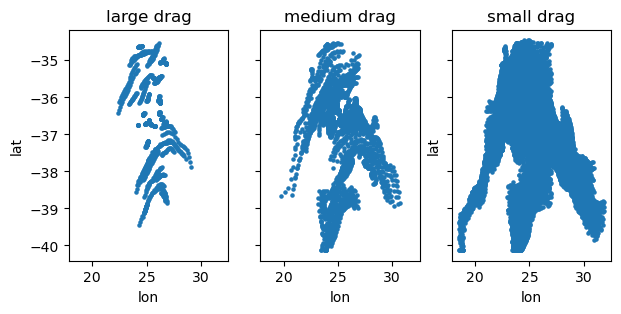

In [16]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(7, 3))

ax[0].scatter(
    ds.where(ds.coeff < 0.33).lon,
    ds.where(ds.coeff < 0.33).lat,
    s=5
)
ax[0].set_title("large drag")
ax[0].set_xlabel("lon")
ax[0].set_ylabel("lat")

ax[1].scatter(
    ds.where((ds.coeff >= 0.33) & (ds.coeff < 0.66)).lon,
    ds.where((ds.coeff >= 0.33) & (ds.coeff < 0.66)).lat,
    s=5
)
ax[1].set_title("medium drag")
ax[1].set_xlabel("lon")

ax[2].scatter(
    ds.where((ds.coeff >= 0.66)).lon,
    ds.where((ds.coeff >= 0.66)).lat,
    s=5
)
ax[2].set_xlabel("lon")
ax[2].set_ylabel("lat")
ax[2].set_title("small drag")
ax[2].set_xlabel("lon")